In [2]:
from __future__ import division
import pandas as pd
import numpy as np

# from pyspark.sql.functions import udf
# from pyspark.sql.types import ArrayType, StringType, FloatType
# from pyspark.sql.functions import mean as sql_mean


import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

% matplotlib inline

## Now that our database is saved as a parquet, we can query it directly

In [3]:
# Use formatting to set table name

table = "parquet.`data/data.parquet`"

spark.sql('''
    SELECT author, words, w2v_2D 
    FROM {}
    LIMIT 10
    '''.format(table)).show()

+--------------+--------------------+--------------------+
|        author|               words|              w2v_2D|
+--------------+--------------------+--------------------+
|CharlesDickens|[a, christmas, ca...|[-0.2198797028459...|
|CharlesDickens|[mind, !, i, do, ...|[-0.1176727883769...|
|CharlesDickens|[scrooge, never, ...|[-0.0100498442707...|
|CharlesDickens|[nobody, ever, st...|[-0.0941561760135...|
|CharlesDickens|[the, door, of, s...|[-0.0963818471919...|
|CharlesDickens|[", i, do, ,, ", ...|[-0.3170365799212...|
|CharlesDickens|[", uncle, !, ", ...|[-0.2647799076317...|
|CharlesDickens|[the, clerk, in, ...|[-0.3749112412266...|
|CharlesDickens|[", i, am, sorry,...|[-0.1319543220445...|
|CharlesDickens|[", mr., marley, ...|[-0.2224757027399...|
+--------------+--------------------+--------------------+



## make dataframes of metadata for each author:

In [164]:
def metadata_df(author):
    table = "parquet.`data/data.parquet`"
    author = "'{}'".format(author)
    return spark.sql('''
        SELECT author, words, w2v_2D
        FROM {} 
        WHERE author = {}
        '''.format(table, author))


twaindf = metadata_df('MarkTwain')
muirdf = metadata_df('JohnMuir')
austendf = metadata_df('JaneAusten')
dickensdf = metadata_df('CharlesDickens')

twaindf.show(5)


authors = ["Twain", "Muir", "Austen", "Dickens"]
table_names = ['MarkTwain', 'JohnMuir', 'JaneAusten', 'CharlesDickens']
DFs = [twaindf, muirdf, austendf, dickensdf]
colors = [(0.1, 0.3, .9), (0.1, 0.75, 0.55), (0.627,0.125,0.941), (0.9, 0.2, 0.1)]


+---------+--------------------+--------------------+
|   author|               words|              w2v_2D|
+---------+--------------------+--------------------+
|MarkTwain|[a, connecticut, ...|[-0.0889031496085...|
|MarkTwain|[“, you, know, ab...|[-0.1227114788563...|
|MarkTwain|[how, sir, launce...|[-0.0495321551874...|
|MarkTwain|[and, then, they,...|[-0.1027905257600...|
|MarkTwain|[as, i, laid, the...|[-0.1342237425533...|
+---------+--------------------+--------------------+
only showing top 5 rows



## w2v scatterplot

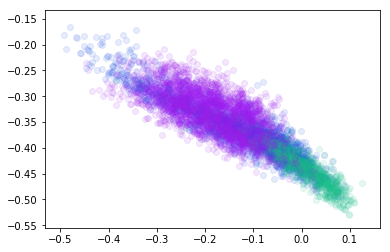

In [167]:
for i, df in enumerate(DFs[:-1]):
    col = df.toPandas().w2v_2D
    x = [r[0] for r in col]
    y = [r[1] for r in col]
    plt.scatter(x, y, color=colors[i], alpha=.1)

## Make Histogram Functions

In [4]:
# thankyou nick for the plotting code
# rework further in my own sparky style 

def make_plots(DFs, col, bins, title, colors, x_lab, authors, x_lim=None, y_lim=None):
    plt.subplots(4,4,sharex=True, sharey=True, figsize=(10,10))
    plt.tight_layout()
    plt.subplots_adjust(top=0.94)
    plt.suptitle(title, fontsize=18)
    for i, DF in enumerate(DFs):
        make_hist(DF, col, bins, colors[i], x_lim, y_lim, i, x_lab, authors[i])
    
    
def make_hist(DF, col, bins, color, x_lim, y_lim, i, x_lab, author):
    # Create pandas DF of bins and counts
    temp_df = DF.select(col).toPandas()
    plt.subplot(2,2,i+1)
    plt.hist(temp_df[col], bins, normed=1, color=color, 
             alpha=0.4, label=author)
    # Find mean sentence length
    x_val = DF.select(sql_mean(col)).select('avg('+col+')').head()[0]
    plt.axvline(x=x_val, color=color, label="Mean", linewidth=1.5)
    plt.xlabel(x_lab)
    plt.ylabel("Frequency")
    plt.xlim(x_lim)
    plt.ylim(y_lim)
    plt.legend();

## Plot Metadata

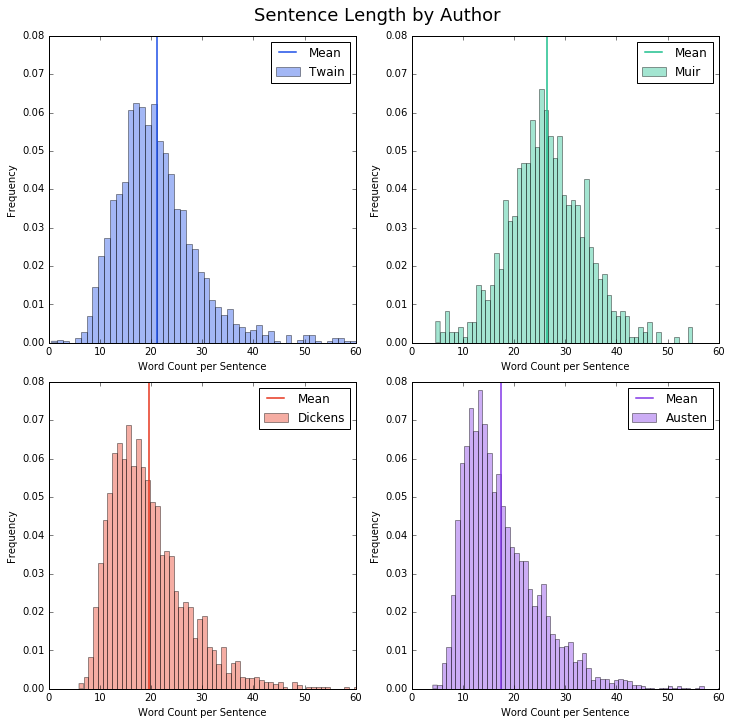

In [15]:
# Make Sentence Length Histograms
make_plots(DFs=DFs, col='sent_length', bins=75, title='Sentence Length by Author',
           colors=colors, x_lim=(0,60), y_lim=(0, 0.08), x_lab="Word Count per Sentence", authors=authors)
plt.savefig('data/images/sent_len.png', bbox_inches='tight')